### Code ReadME
This code is a simple completion for paper: On Measuring and Controlling the Spectral Bias of the Deep Image Prior using image F16, the output PSNR is

### Import Package

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%reload_ext autoreload
%autoreload 2
from __future__ import print_function
import sys
sys.path.append("..")
from module.spectual_norm_DIP import *

import torch
import torch.optim
from skimage.metrics import peak_signal_noise_ratio
from util.measure_utils import *
from util.common_utils import *
from util.visual_utils import *
from util.gaussian_util import *
from torch.utils.tensorboard import SummaryWriter
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

### Name and path

In [7]:
name = 'spectual_bias_DIP_denoise_image_F16_512rgb'
log_path_prefix ='../log'
img_path = '../data/denoising/image_F16_512rgb.png'
save_img_path_prefix = '../output'

log_dir = os.path.join(log_path_prefix, name)
save_img_dir = os.path.join(save_img_path_prefix, name)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(save_img_dir):
    os.makedirs(save_img_dir)
writer = SummaryWriter(log_dir)

### Import data and show

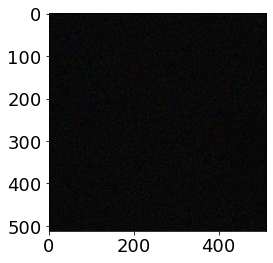

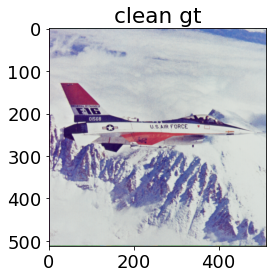

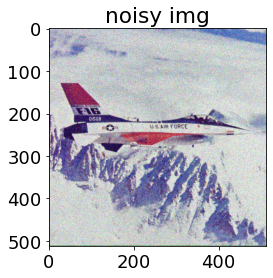

origin PSNR is:20.372250953739872
[[[0.6658937  0.6625676  0.6631614  ... 0.56596637 0.4587967  0.63479584]
  [0.74981624 0.8085999  0.8697088  ... 0.5692757  0.80118346 0.34868538]
  [0.5905429  0.7937242  0.90896636 ... 0.4912958  0.7573575  0.30056316]
  ...
  [0.54435354 0.83889157 0.9870436  ... 0.6366213  0.612124   0.6341469 ]
  [0.6264645  0.96390927 0.9021034  ... 0.49127018 0.5754877  0.4495726 ]
  [0.0311353  0.         0.00343214 ... 0.4345637  0.40239573 0.3588614 ]]

 [[0.09846559 0.89789605 0.69817036 ... 0.58689845 0.7803791  0.5681549 ]
  [0.         0.73499894 0.92896026 ... 0.6444086  0.63908666 0.47369277]
  [0.         0.6384175  0.6841931  ... 0.84290195 0.66433287 0.5189322 ]
  ...
  [0.         0.7600859  0.7551755  ... 0.60539925 0.7065998  0.71238655]
  [0.         0.87222767 1.         ... 0.60027224 0.66440225 0.70140994]
  [0.3968938  0.360693   0.2963847  ... 0.5610901  0.5457053  0.45391005]]

 [[0.4746652  0.7762747  0.76662177 ... 0.91193205 0.8022627  

In [8]:
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

# noise level
sigma = 25
sigma_ = sigma/255.
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

noise = np.clip((img_noisy_np - img_np), 0, 1)
plt.imshow(np_to_pil(noise))
plt.show()
np_to_pil(noise).save('../data/image_noise.png')

plt.imshow(img_pil)
plt.title('clean gt')
plt.show()
plt.title('noisy img')
plt.imshow(img_noisy_pil)
plt.show()
print("origin PSNR is:{}".format(peak_signal_noise_ratio(img_np, img_noisy_np)))
print(img_noisy_np)

### Net prepare

In [9]:
INPUT = 'fourier' # 'meshgrid', 'noise', 'fourier'
var=1
input_depth = 32
net_input = get_noise(input_depth, INPUT, (img_pil.size[1]//32, img_pil.size[0]//32),var=var).type(dtype).detach()

#network parameters
ln_lambda=1.4#the lambda in Lipschitz normalization, which is used to control spectral bias
upsample_mode='bilinear'#['deconv', 'nearest', 'bilinear', 'gaussian'], where 'gaussian' denotes our Gaussian upsampling.
pad = 'reflection'
#decoder is the used network architecture in the paper
net = decoder(num_input_channels=input_depth, num_output_channels=3, ln_lambda=ln_lambda,
                   upsample_mode=upsample_mode, pad=pad, need_sigmoid=True, need_bias=True).type(dtype)

#optimization parameters
OPTIMIZER='adam'
num_iter = 10000
LR = 0.001
reg_noise_std = 0#1./30, injecting noise in the input.
show_every = 100

#automatic stopping
ratio_list = np.zeros((num_iter))
ratio_iter=100#the n in Eq. (8)
ratio_epsilon=0.01#the ratio difference threshold
auto_stop = False

# Loss
mse = torch.nn.MSELoss().type(dtype)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
last_net = None
psrn_noisy_last = 0

i = 0
def closure():

    global i, out, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt    = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0])

    pre_img = out.detach().cpu().numpy()[0]
    pre_img = pre_img.transpose(1, 2, 0)
    noisy_img = img_noisy_np.transpose(1, 2, 0)

    #frequency-band correspondence metric
    avg_mask_it = get_circular_statastic(pre_img, noisy_img,  size=0.2)

    #automatic stopping
    blur_it = PerceptualBlurMetric (pre_img)#the blurriness of the output image
    sharp_it = MLVSharpnessMeasure(pre_img)#the sharpness of the output image
    ratio_it = blur_it/sharp_it#the ratio

    # print ('Iteration: %05d, Loss: %f, PSRN_gt: %f' % (i, total_loss.item(), psrn_gt))
    writer.add_scalar('PSNR_GT', psrn_gt, i)
    writer.add_scalar('Loss', total_loss.item(), i)
    writer.add_scalar('Mask/brand 0', avg_mask_it[0], i)
    writer.add_scalar('Mask/brand 1', avg_mask_it[1], i)
    writer.add_scalar('Mask/brand 2', avg_mask_it[2], i)
    writer.add_scalar('Mask/brand 3', avg_mask_it[3], i)
    writer.add_scalar('Mask/brand 4', avg_mask_it[4], i)
    """log_file.write('Iteration: %05d, Loss: %f, PSRN_gt: %f, mask: %s, ratio: %f\n' % (i, total_loss.item(), psrn_gt, avg_mask_it, ratio_it))
    log_file.flush()"""

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

### Train

In [10]:
optimize(OPTIMIZER, net.parameters(), closure, LR, num_iter)

Starting optimization with ADAM


### Model saved & output Saved

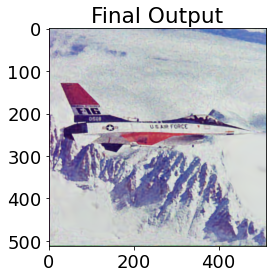

In [11]:
torch.save(net, os.path.join(save_img_dir,  'model.pth'))
if reg_noise_std > 0:
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)
out = net(net_input)

output_img_np = torch_to_np(out)
output_img_pil = np_to_pil(output_img_np)
plt.imshow(output_img_pil)
plt.title('Final Output')
plt.show()
writer.add_image('Final Output', output_img_np)